# Part II - Spatial Logistic Regression
This is the **second** notebook in a series of 3 that will work through predicting wildfire incidence using historical wildfire, climatology, and land usage data.

At this point we have already preprocessed our data from the 3 sources such that all datasets have the same resolution and size. For 10-minute resolution data, the shape is 153 by 351.

## Methodology Overview
However, it is still not yet at point where we can simply pass the matrix through to the model. For each center cell, we must grab the values in all cells that are an L1 distance of $\ell$ away from the center, where $1\leq \ell \leq L$, where $L$ is the maximum distance we decide to look out.

One sample will constitute of the input values **for each** $\mathbf{\ell}$
* The percentage of cells at that distance that had a fire.
* For each metric we choose to include, the average of the metric at that distance of $\ell$.
* For each land cover category, the percentage of cells at that distance that had that type of land.

In our case, since we have both minimum and maximum temperature, we will only use the **average temperature** in order to avoid directly correlating variables.

Once we have our matrix, we can pass it directly through the logistic regression model. We will also allow for some minor scaling of values, and showcase the effects of them.

Every resolution will generate a new input matrix and new target values. To minimize complexity, we will use the most coarse resolution of **10 minutes**. To run other resolutions, please adjust the variable in the notebook accordingly.

Let's get started!

## Import Packages
As always, we will import all the packages we need. In addition to the usual data analytics, we use multiple capabilities from `sklearn` that will aid in preprocessing and building the model itself.


In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report

# Ignore some of the division by zero warnings, as we take 
# care of them ourselves.
np.seterr(divide='ignore', invalid='ignore', over='ignore')
np.random.seed(7145)

## Setting up
We have a good amount of setup to do, such as reading in the files, making the final DataFrame that will house all the samples.

### Metadata
First, define our maximum lag distance $L$, the metrics we will use, the resolution, and directory locations.

In [2]:
LAG = 5
metric_names = ['tavg', 'prec', 'srad', 'wind', 'vapr']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
RES = '10m'

ROOT = '../'
PREFIX = os.path.join(ROOT, 'data')
PROCESSED_PATH = os.path.join(PREFIX, 'processed', RES)

### Reading in Data
Read in the fires, land cover, and climatology data at the specified resolution. In addition, we also grab the actual land cover categories, and also transpose the `metrics` matrix so that the month dimension is at the very front. This will come in handy when we "unwrap" and put into DataFrame format. Finally, we also force the fire matrix to contain binary incidence data, as opposed to direct frequency.

In [3]:
# Read in the fires and landcover data
# Make the fires become binary.
fires = np.load(os.path.join(PROCESSED_PATH, 'fires.npy')).clip(0, 1)
landcover = np.load(os.path.join(PROCESSED_PATH, 'lc.npy'))
# Put 0s in for all the NaNs, and convert to integer, will save some headache.
landcover[np.isnan(landcover)] = 0
landcover = landcover.astype(int)

# Stack the selected metrics into a single ndarray
metrics = np.stack([np.load(os.path.join(PROCESSED_PATH, f'{metric}.npy')) for metric in metric_names])
# We want the months to be the first dimension, so do a transpose
metrics = metrics.transpose((1, 0, 2, 3))
print('Metrics shape:', metrics.shape)

landcover_cats = np.unique(landcover).tolist()[1:]  # Don't want 0
print(f'Land cover categories: {landcover_cats}')
# Save the shape, we'll do product() later :)
N_ROWS, N_COLS = fires[0].shape
print(N_ROWS, N_COLS)

Metrics shape: (12, 5, 153, 351)
Land cover categories: [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
153 351


### Columns of final DataFrame
Based on the bullet points for the column contained in the actual input matrix, it will be handy to generate what these column names would be for each value of $\ell$.

In [4]:
# Create the column names...
# We will need to reference the fire names, metric names, and
# land cover names separately, so create a dictionary.
fire_colnames = {}
metric_colnames = {}
landcover_colnames = {}

# Create all the column names and add them to the correct dictionary
for lag in range(1, LAG + 1):
    fire_colnames[lag] = f'fires_L{lag}_%'
    metric_colnames[lag] = [f'{metric}_L{lag}_avg' for metric in metric_names]
    landcover_colnames[lag] = [f'LC{lc}_L{lag}_%' for lc in landcover_cats]

# Add all columns to a big list to
# create the ultimate dataframe...
colnames = ['Month']
for lag in range(1, LAG + 1):
    colnames.append(fire_colnames[lag])
    colnames.extend(metric_colnames[lag])
    colnames.extend(landcover_colnames[lag])

# Add a column for incidence of fire in the center...
colnames.append('fireCenter')

### Valid Locations
Not every cell in the matrix will have all the available cells. For example, cells on the top edge won't have any values above it. For this reason, we will create a mask of all the places where we have full cell availability, and combine with the NaNs present in the data already.

In [5]:
# The locations we can lag is determined by our
# LARGEST lag. The list of center locations we can
# gather stay constant throughout the process
laggable = np.ones((N_ROWS, N_COLS), dtype=bool)
laggable[-LAG:, :] = False
laggable[:LAG, :] = False
laggable[:, :LAG] = False
laggable[:, -LAG:] = False
# Where values aren't masked and are laggable
fire_row_centers, fire_col_centers = np.where(~np.isnan(fires[0]) & laggable)
print('Number of centers:', len(fire_row_centers))

# Our full dataframe
spatial_reg = pd.DataFrame(data=None, columns=colnames)
# For the month, all of January will be there, then February, etc.
# The number of centers we have is how many times each month will
# show up, so use np.repeat and fill it in right now.
spatial_reg['Month'] = np.repeat(months, repeats=len(fire_row_centers))
spatial_reg['fireCenter'] = fires[:, fire_row_centers, fire_col_centers].ravel()
print('Shape of final DataFrame:', spatial_reg.shape)

Number of centers: 30522
Shape of final DataFrame: (366264, 112)


The final number of rows our Dataframe will have is the number of centers multiplied by 12 (the number of months).

### Getting the cell neighbors
This step is much more involved. For each center cell, we need to grab the indices of all the cells that are a distance of $\ell$ away from the center.

We can take advantage of 4-fold symmetry (in the 4 directions) to do this efficiently. We will also calculate the **distance** between the center and each point in the $x$ and $y$ direction, so we can simply add when it's all said and done. 

The set of points we want form a diamond of pixels around the center. We will focus on the **top right trinagle** when we loop over possible values. The distance to the x-coordinate will range $0\leq x_d \leq \ell$. This also means that the distance to y-coordinate $y_d=\ell - x_d$.
 
The distance coordinates range from $(x_d, y_d) = (0, \ell)$ to $(\ell, 0)$. At the two endpoints, there is only *one point opposite* ($(0, -\ell)$ and $(-\ell, 0)$). At all other points, we need 4 corresponding points: $(x_d, y_d), (-x_d, y_d), (x_d, -y_d), (-x_d, -y_d)$. 

Once we have the full set, we just take our center point $(x_c, y_c)$ and add it to each point in the set.

We will put this functionality in a function `get_cell_neighbors`.

In [6]:
def get_cell_neighbors(center, lag, width, height):
    # Local function to test whether a location is within the bounds
    in_bounds = lambda r, c: (0 <= r < height) and (0 <= c < width)
    # Currently, (0, 0) in array style is top corner.
    # Imagine we had a regular coordinate system instead.
    # The squares form a diamond shape. By keeping track
    # of the x and y distance from the center, we can form all 4 sides at once
    # by going along just one of them.
    # We will go along the top right side, which corresponds
    # to initial positive x and y distance.
    # Ex. lag = 2 ==> (0, 2), generates (0, -2)
    # next: (1, 1), generates (-1, 1), (1, -1), and (-1, -1)
    # next: (2, 0) generates (-2, 0)
    # We'll deal with the center afterwards...
    points = []
    for x_dist in range(lag + 1):
        y_dist = lag - x_dist
        if x_dist == 0:  # Only need one other point...
            points.extend([
                (x_dist, y_dist),
                (x_dist, -y_dist)  # Bottom corner
            ])
        elif y_dist == 0:
            points.extend([
                (x_dist, y_dist),
                (-x_dist, y_dist)  # Left corner
            ])
        else:
            points.extend([
                (x_dist, y_dist),  # Top right
                (-x_dist, y_dist),  # Top left
                (x_dist, -y_dist),  # Bottom right
                (-x_dist, -y_dist)  # Bottom left
            ])
    # Filter out points that are outside of bounds...
    # And add the center while we're at it...
    # The array style coordinates is regular
    # Cartesian that's been rotated 90 degrees CW
    points = [(center[0] + r, center[1] + c) for r, c in points if in_bounds(center[0] + r, center[1] + c)]
    return tuple(zip(*points))

Now we just need to call this function for every single center we have in our list. The benefit of pre-calculating them is so that we can index directly into the Numpy matrices all at once, which saves a lot of time. The general rule-of-thumb when working with Numpy is to use as few loops as possible.

In [7]:
# Get lagged locations for each cell...
# at each possible lag....
all_locs = {
    lag: [get_cell_neighbors((i, j), lag, N_COLS, N_ROWS)
          for i, j in zip(fire_row_centers, fire_col_centers)]
    for lag in range(1, LAG + 1)
}
print(f'Sample of lagged locations (lag=2), (center={fire_row_centers[0], fire_col_centers[0]}):', all_locs[2][0])

Sample of lagged locations (lag=2), (center=(5, 179)): ((5, 5, 6, 4, 6, 4, 7, 3), (181, 177, 180, 180, 178, 178, 179, 179))


## Calculating statistics of lagged locations
Now that we have the centers, as well as the indices of the lagged locations for each $\ell$, we can now grab those values and calculate averages. When indexing into a Numpy array, it is required to give 2 lists, one for the row indices, and one for the column indices. This is similar to what we have; however, they have been split up in `all_locs`. To merge them into 2 distinct lists, while also keeping the order of data consistent, we need to do a transpose along with a reshape.

**Let us first walkthrough with $\mathbf{\ell=1}$ and then loop it around afterward.** With a lag of 1, there are only 4 neighboring values we need to worry about.

In [8]:
lag = 1
# Extract the lag locations for each center, and reshape into a 2 x num_points array,
# so a single indexing can be performed on our datasets.
locs_lag = np.asarray(all_locs[lag], dtype=int)
N_POINTS, N_LAGGED = locs_lag.shape[0], locs_lag.shape[-1]
locs_lag = locs_lag.transpose((1, 0, 2)).reshape(2, N_POINTS * N_LAGGED)
rows, cols = locs_lag[0].tolist(), locs_lag[1].tolist()

In [9]:
print(f'Centers of ({fire_row_centers[0], fire_col_centers[0]}), ({fire_row_centers[0], fire_col_centers[1]}), ({fire_row_centers[0], fire_col_centers[2]})')
rows[:12], cols[:12]

Centers of ((5, 179)), ((5, 180)), ((5, 181))


([5, 5, 6, 4, 5, 5, 6, 4, 5, 5, 6, 4],
 [180, 178, 179, 179, 181, 179, 180, 180, 182, 180, 181, 181])

Notice that we have generated 2 *flattened* lists of the lagged locations.

### Averaging wildfire incidence
With the two index lists now ready, we can index directly into the `fires` Numpy array, grab the incidences, and average them across all lagged locations. The locations also don't change from month to month. In order to handle the NaNs that are present, we use `np.nanmean()` instead of the `np.mean()`. The former will ignore NaNs when calculating the mean. Once this is done, we simply flatten the list and assign to the our `spatial_reg` Dataframe!

In [10]:
# Calculate fire incidences for all the months at all the locations.
# shape = (12, n_points, n_lagged)
# Then, take the mean of each point for its lagged locations
# corresponds to the last axis ==> (12, n_points).
# Then, we assign it to the dataframe by raveling to a single column.
# This preserves the month order we added in earlier.
fire_incidences = fires[:, rows, cols].reshape((-1, N_POINTS, N_LAGGED))
# Catch the "mean of empty slice" warning...
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    fire_incidences = np.nanmean(fire_incidences, axis=-1)
# Assign it to the corresponding column for fire
spatial_reg[fire_colnames[lag]] = fire_incidences.ravel()
print(spatial_reg[fire_colnames[lag]].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: fires_L1_%, dtype: float32


### Calculate averages for all metric values
Because the metrics are the same shape as the fire matrix, the same exact indices apply here. The only extra step we need is an extra transpose, because currently, the metrics are in the second dimension. Transposing the axes so that the metrics are the final dimension (and consequently, the points are the second dimension) will ensure that each metric forms a column when assigning it to the DataFrame.


In [11]:
# Calculate all metrics all at once using the same idea as before.
# Extra dimension here ==> 12 x n_metrics x n_points x n_lagged.
# Take mean on last axis, but then swap the last two axes, so that
# the number of metrics is at the end ==> 12 x n_points x n_metrics.
# Then flatten the first wo dimensions, and add it to the dataframe.
collected_metrics = metrics[..., rows, cols].reshape((12, -1, N_POINTS, N_LAGGED))
# Catch the "mean of empty slice" warning...
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    collected_metrics = np.nanmean(collected_metrics, axis=-1).transpose((0, 2, 1))
spatial_reg[metric_colnames[lag]] = collected_metrics.reshape((-1, len(metric_names)))
spatial_reg[metric_colnames[lag]].head()

,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg
0,-17.215083,18.0,4447.666667,3.445333,0.165133
1,-17.008937,18.5,4425.500000,3.405188,0.165156
2,-16.799875,17.5,4429.000000,3.361625,0.168513
3,4.225424,117.0,3243.000000,3.450847,0.680000
4,3.318625,144.5,3287.000000,3.139708,0.643800


### Land Cover Percentage
The land cover usage is last. Like before, we will use the same indexing. However, we need a few extra steps if we want to calculate the percentage of **each** land cover category. Luckily, both Numpy and Pandas have convenient functions. 

First, after grabbing the land cover values and reshaping so that the number of columns is the number of lagged points, we insert into a DataFrame. Then, we `stack()` which places each row on top of each other, while also creating a hierarchical index, with levels being the row index and column name. Then, we `groupby()` by the first level, and call `value_counts()` on the ensuing groups. This will count the number of times each land cover category appears in each row. Then we simply undo our stacking with `unstack()`.

Some extra tidbits is that we had the value of 0 in the beginning, and so we drop this column count in the end. Once we have the counts, we just divide by the sum in each row and we have our percentages. To assign to our `spatial_reg` DataFrame, we have to repeat the values for each month.

In [12]:
# Land cover is last.
# We index the same way, but we have to calculate percentages of each land cover category.
# To do this, we put the matrix into a dataframe, and then call a bunch of functions.
#  - stack() ==> A single column dataframe with a multi-index of row then column.
#  - groupby() ==> Group by the first level, which in this case is the 0.
#  - value_counts() ==> Counts number of distinct values in each group i.e. row
#  - unstack() ==> Reverses the stack operation, and puts 0 in places of missing row column pairs.
#  - drop ==> Drops the "0" column i.e. the counts of 0, as this was a placeholder.
lcs_df = pd.DataFrame(landcover[rows, cols].reshape((N_POINTS, N_LAGGED)), dtype=object)
cat_counts = lcs_df.stack().groupby(level=0).value_counts().unstack(fill_value=0).drop(columns=[0])
# Divide each row by its sum (and converts back to ndarray)
cat_counts = cat_counts.div(cat_counts.sum(axis=1), axis=0).values
# Right now, we have as many rows as points, so just repeat them
# for each month we have.
# The regular repeat will repeat in-place which isn't what we want.
# Instead, expand into an axis, repeat on the outer axis, and get rid
# of it afterwards.
unwrapped = np.repeat(cat_counts[np.newaxis, ...], repeats=12, axis=0).reshape((-1, len(landcover_cats)))
spatial_reg[landcover_colnames[lag]] = unwrapped
spatial_reg[landcover_colnames[lag]].head()

,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,LC23_L1_%,LC24_L1_%,LC31_L1_%,LC41_L1_%,LC42_L1_%,LC43_L1_%,LC52_L1_%,LC71_L1_%,LC81_L1_%,LC82_L1_%,LC90_L1_%,LC95_L1_%
0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
1,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0
2,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0


That takes care of the lag value of 1. For the rest, we will just place the above steps in a loop.
### Preprocessing the rest of the lag values

In [13]:
for lag in range(2, LAG + 1):
    print(f'Doing lag of {lag}...', end='')
    # Extract the lag locations for each center, and reshape into a 2 x num_points array
    locs_lag = np.asarray(all_locs[lag], dtype=int)
    N_POINTS, N_LAGGED = locs_lag.shape[0], locs_lag.shape[-1]
    locs_lag = locs_lag.transpose((1, 0, 2)).reshape(2, N_POINTS * N_LAGGED)
    rows, cols = locs_lag[0].tolist(), locs_lag[1].tolist()

    # Calculate fire incidences for all the months at all the locations
    fire_incidences = fires[:, rows, cols].reshape((-1, N_POINTS, N_LAGGED))
    # Catch the "mean of empty slice" warning...
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        fire_incidences = np.nanmean(fire_incidences, axis=-1)
    spatial_reg[fire_colnames[lag]] = fire_incidences.ravel()

    # Calculate all metrics all at once using the same idea as before
    collected_metrics = metrics[..., rows, cols].reshape((12, -1, N_POINTS, N_LAGGED))
    # Catch the "mean of empty slice" warning...
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        collected_metrics = np.nanmean(collected_metrics, axis=-1).transpose((0, 2, 1))
    spatial_reg[metric_colnames[lag]] = collected_metrics.reshape((-1, len(metric_names)))

    # Land cover is last
    lcs_df = pd.DataFrame(landcover[rows, cols].reshape((N_POINTS, N_LAGGED)), dtype=object)
    cat_counts = lcs_df.stack().groupby(level=0).value_counts().unstack(fill_value=0).drop(columns=[0])
    cat_counts = cat_counts.div(cat_counts.sum(axis=1), axis=0).values
    unwrapped = np.repeat(cat_counts[np.newaxis, ...], repeats=12, axis=0).reshape((-1, len(landcover_cats)))
    spatial_reg[landcover_colnames[lag]] = unwrapped

    print('Done!')

Doing lag of 2...Done!
Doing lag of 3...Done!
Doing lag of 4...Done!
Doing lag of 5...Done!


## Logistic Regression
We're finally ready to perform our logistic regression. There will be a few steps in preparing our data:
* Removing exactly one land cover category to remove multicollinearity.
* Perform a train test split of the data, with the training set being 80% of the full data (and hence the test size being 20%).
* Fit logistic regression and show the results!

In [14]:
# First handle the multicollinearity.
for lag in range(1, LAG + 1):
    spatial_reg.drop(columns=f'LC95_L{lag}_%', inplace=True)
# Get rid of rows with NaNs in them...
spatial_reg = spatial_reg.dropna()
# Do a train test split
train_indices, test_indices = train_test_split(np.arange(spatial_reg.shape[0]), test_size=0.2)
print('Train size:', len(train_indices))
print('Test size:', len(test_indices))
train_set = spatial_reg.iloc[train_indices]
test_set = spatial_reg.iloc[test_indices]

Train size: 292944
Test size: 73236


Looks like we have just 300 thousand fires to fit the regression, and we will evaluate the performance on about 73 thousand. For logistic regression, we will use `sklearn`'s implementation. The target column will be our `fireCenter` column, while our inputs will be the rest of the columns, except the month column.

In [15]:
# Split the input from output
X_train = train_set.iloc[:, 1:-1]
y_train = train_set['fireCenter']
X_test = test_set.iloc[:, 1:-1]
y_test = test_set['fireCenter']

In [16]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Get the predictions
predictions = logreg.predict(X_test)

# Calculate performance with the test set
print(classification_report(y_true=y_test, y_pred=predictions, target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.76      0.98      0.86     55761
        Fire       0.35      0.03      0.06     17475

    accuracy                           0.75     73236
   macro avg       0.56      0.51      0.46     73236
weighted avg       0.67      0.75      0.67     73236


C:\Users\mughi\miniconda3\envs\wildfire_p310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


While the accuracy of 75% looks like a good mark. notice how low the F1 score is for samples with fires. Additionally, we can also check the "null" accuracy. This is the accuracy we get if we predicted the majority class for all samples, in this case, the accuracy for predicting not a single fire happens. 

In [17]:
print(f'Null accuracy {(1 - np.mean(y_test)) * 100:2.3f}%')

Null accuracy 76.139%


This tells us our model actually did **worse** than simply predicting not a single fire occurred.

### Scaling and Class Balancing
There are two main issues at play that caused our model to perform poorly, especially with respect to samples that actually had fires.

#### Class Balancing
One main issue with the data is the heavy class imbalance that is present. The null accuracy clued us in to this, but much more than half of all samples contain no fires. This forces the regression model to bias towards "no fire" in order to minimize its error and loss functions. To mitigate this, we can have the regression only see an equal number of each class, so that each is weighted equally.

In practice, this amounts to randomly sampling from the "no fire" subset as many "fire" samples we have, and merging the two datasets. Once again, we only do this in the train set, and leave the test set unaffected. Additionally, we have to carry the target data as well, so that it gets sampled and shuffled the same way.

In [18]:
# Equalize the number of positive and negative samples in the training set...
no_fire_samples = train_set[train_set['fireCenter'] == 0]
fire_samples = train_set[train_set['fireCenter'] == 1]
# Randomly choose the number of 1 samples we have from the no fire samples
chosen_no_fire_samples = no_fire_samples.sample(n=fire_samples.shape[0])
# Concatenate both sets together, and shuffle with .sample(frac=1)
train_set = pd.concat((chosen_no_fire_samples, fire_samples), axis=0, ignore_index=True).sample(frac=1)
print('New number of records:', train_set.shape[0])
print('New proportion of fires:', np.mean(train_set['fireCenter']))

# Split off X and y train again
X_train = train_set.iloc[:, 1:-1]
y_train = train_set['fireCenter']

New number of records: 140198
New proportion of fires: 0.5


And that's it! One downside of this is that our total number of records decreases. However, we already have thousands of them, and the equal class weighting is much more important than the number of samples we have.

#### Rescaling the data
Another issue is that the scale of the metric values vary wildly. Let's take a glance at just a few.

In [19]:
spatial_reg[metric_colnames[1]].head()

,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg
0,-17.215083,18.0,4447.666667,3.445333,0.165133
1,-17.008937,18.5,4425.500000,3.405188,0.165156
2,-16.799875,17.5,4429.000000,3.361625,0.168513
3,4.225424,117.0,3243.000000,3.450847,0.680000
4,3.318625,144.5,3287.000000,3.139708,0.643800


Notice the size of the values for the solar radiation, compared to the other columns, especially water vapor. It is generally difficult for any model to deal with very large values like this, especially across multiple scales. The easiest way to mitigate is to real scale all the columns to be much smaller. 

There are a few types of scaling we can do. Either we can do a simple minmax scaler, where all values are rescaled to be between 0 and 1, or normal scaler, where the data is centered and scaled to have a mean of 0 and standard deviation of 1. Another option in cases of skewed data is to apply power transformation, which makes the data a bit more normal. Which scaling we use is dependent on the shape of the data, so we'll need a few histograms.

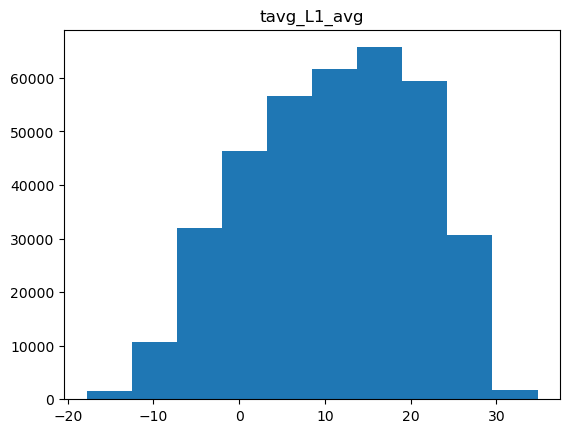

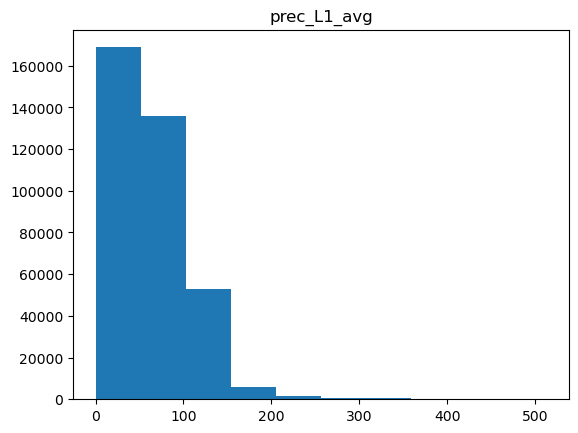

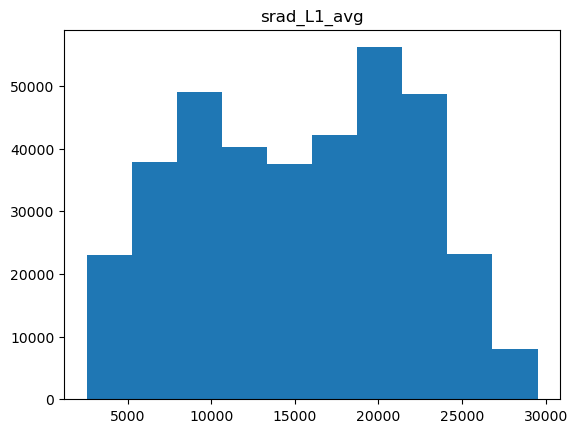

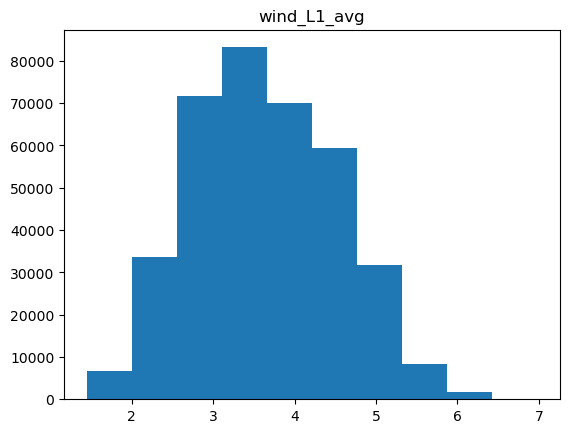

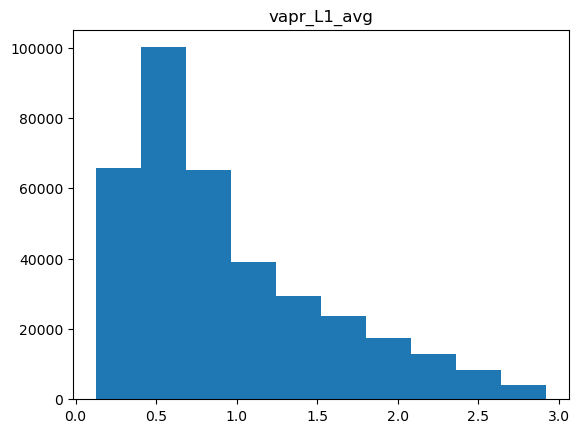

In [20]:
for col in metric_colnames[1]:
    fig = plt.hist(spatial_reg[col])
    plt.title(col)
    plt.savefig(f'{col}.png')
    plt.show()

Of the 5 metrics we have, only precipitation and water vapor appear to have heavily skewed distributions, while the rest are fairly normal. Therefore, we can apply normal scaling to average temperature, solar radiation, and wind, and power transformations to both precipitation and water vapor.

A very important thing to remember is that we want to calculate any parameters **with respect to the training data.**, and then use these parameters to scale the testing data. This is because the test data should act as "unseen" data.

To apply different transformations to different columns of the data, we'll use the `make_column_transformer()` method from `sklearn`. This lets us choose which columns to apply the `StandardScaler` and `PowerTransformer` to. We do need to make lists of the column though.

In [21]:
standard_cols = [col for col in colnames if any(col.startswith(metric) for metric in ['tavg', 'srad', 'wind'])]
power_cols = [col for col in colnames if any(col.startswith(metric) for metric in ['prec', 'vapr'])]

transform = make_column_transformer(
    (StandardScaler(), standard_cols),
    (PowerTransformer(method='yeo-johnson'), power_cols),
    remainder='passthrough',  # To avoid dropping columns we DON'T transform
    verbose_feature_names_out=False  # To get the final mapping of input to output columns without original transformer name.
)

In [22]:
transform.fit_transform(X_train)

array([[ 0.55481193, -0.1663762 , -0.40291726, ...,  0.15      ,
         0.45      ,  0.        ],
       [ 2.16198943,  1.2894434 , -0.05394126, ...,  0.        ,
         0.05      ,  0.        ],
       [-1.87861788, -1.78230941,  0.89705361, ...,  0.        ,
         0.15      ,  0.05      ],
       ...,
       [-0.35749476, -0.46013255,  1.43565403, ...,  0.        ,
         0.2       ,  0.        ],
       [-0.33797301, -0.69837035,  0.33559366, ...,  0.        ,
         0.28571429,  0.28571429],
       [ 1.26715501,  0.96468724, -1.64556632, ...,  0.1       ,
         0.        ,  0.05      ]])

One slight snag of the `ColumnTransformer` is that all the column names get wiped in the output. Worse still, they are also reordered such that all the transformed columns are at the beginning, with the unaffected columns at the end. In order to reorder these columns according to our original `X_train`, we need to do a little trickery. The exact feature name ordering can be had with `.get_feature_names_out()`. Then we find what index in the new ordering each column in the original is at, and then reorder it!

In [23]:
# Create a transformed DataFrame, with the transformed data, and the new column ordering
X_transform = pd.DataFrame(data=transform.transform(X_train), columns=transform.get_feature_names_out(transform.feature_names_in_))
X_transform.head()

,tavg_L1_avg,srad_L1_avg,wind_L1_avg,tavg_L2_avg,srad_L2_avg,wind_L2_avg,tavg_L3_avg,srad_L3_avg,wind_L3_avg,tavg_L4_avg,...,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%
0,0.554812,-0.166376,-0.402917,0.558304,-0.166874,-0.418769,0.559111,-0.167345,-0.435037,0.558941,...,0.0,0.00,0.05,0.00,0.1,0.00,0.00,0.15,0.45,0.00
1,2.161989,1.289443,-0.053941,2.140721,1.289216,-0.059216,2.107438,1.285315,-0.062167,2.089913,...,0.0,0.15,0.00,0.00,0.0,0.60,0.20,0.00,0.05,0.00
2,-1.878618,-1.782309,0.897054,-1.885974,-1.786020,0.902043,-1.872196,-1.788702,0.916444,-1.864821,...,0.0,0.00,0.00,0.20,0.0,0.00,0.00,0.00,0.15,0.05
3,0.618095,0.543340,1.201672,0.623555,0.541736,1.195435,0.622905,0.539896,1.205114,0.625178,...,0.0,0.00,0.10,0.05,0.0,0.00,0.50,0.10,0.10,0.00
4,0.717956,0.813319,0.268686,0.710673,0.811974,0.271340,0.714470,0.814537,0.260764,0.730121,...,0.0,0.00,0.00,0.05,0.0,0.35,0.45,0.00,0.10,0.00


In [24]:
# Now, find the new index ordering
col_index_ordering = [X_transform.columns.get_loc(orig_col) for orig_col in X_train.columns]
# Reindexing into the column list with the new indices will automatically reorder them!
X_transform = X_transform[X_transform.columns[col_index_ordering]]
X_transform.head()

,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,...,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%
0,0.0,0.554812,0.478852,-0.166376,-0.402917,0.912618,0.00,0.0,0.0,0.0,...,0.0,0.00,0.05,0.00,0.1,0.00,0.00,0.15,0.45,0.00
1,0.0,2.161989,-1.262072,1.289443,-0.053941,0.844680,0.00,0.0,0.0,0.0,...,0.0,0.15,0.00,0.00,0.0,0.60,0.20,0.00,0.05,0.00
2,0.0,-1.878618,-0.201889,-1.782309,0.897054,-1.608390,0.75,0.0,0.0,0.0,...,0.0,0.00,0.00,0.20,0.0,0.00,0.00,0.00,0.15,0.05
3,0.0,0.618095,0.522388,0.543340,1.201672,0.777671,0.00,0.0,0.0,0.0,...,0.0,0.00,0.10,0.05,0.0,0.00,0.50,0.10,0.10,0.00
4,0.0,0.717956,-0.554168,0.813319,0.268686,0.344607,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.05,0.0,0.35,0.45,0.00,0.10,0.00


And just like that, we have it in the original ordering. At this point, we are ready to pass the updated data through the logistic regression one more time!
### Logistic Regression after data scaling
We follow the same steps as before. This time, we need to process `X_test` using the scaling parameters we developed for `X_train`.

In [25]:
X_test_transform = pd.DataFrame(data=transform.transform(X_test), columns=transform.get_feature_names_out(transform.feature_names_in_))
X_test_transform = X_test_transform[X_test_transform.columns[col_index_ordering]]
X_test_transform.head()

,fires_L1_%,tavg_L1_avg,prec_L1_avg,srad_L1_avg,wind_L1_avg,vapr_L1_avg,LC11_L1_%,LC12_L1_%,LC21_L1_%,LC22_L1_%,...,LC24_L5_%,LC31_L5_%,LC41_L5_%,LC42_L5_%,LC43_L5_%,LC52_L5_%,LC71_L5_%,LC81_L5_%,LC82_L5_%,LC90_L5_%
0,0.00,0.897023,-0.065626,1.177352,0.927326,0.901067,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.00,0.25,0.55,0.00,0.20,0.00
1,0.75,-0.780239,-0.395039,-0.757910,0.963695,-0.754241,0.0,0.0,0.0,0.0,...,0.0,0.0,0.35,0.000000,0.00,0.00,0.35,0.05,0.10,0.00
2,0.75,0.341675,0.302718,0.639931,0.973089,0.685686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.333333,0.00,0.00,0.00,0.00,0.25,0.25
3,0.50,0.455800,-0.727034,-0.013798,1.114007,0.251080,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.05,0.00,0.65,0.15,0.10,0.05
4,0.25,1.227284,0.818776,0.361401,0.529998,1.224845,0.0,0.0,0.0,0.0,...,0.0,0.0,0.05,0.000000,0.00,0.25,0.40,0.00,0.20,0.00


In [26]:
logreg = LogisticRegression()
logreg.fit(X_transform, y_train)
predictions = logreg.predict(X_test_transform)
print(classification_report(y_true=y_test, y_pred=predictions, target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.92      0.85      0.88     55761
        Fire       0.61      0.78      0.69     17475

    accuracy                           0.83     73236
   macro avg       0.77      0.81      0.78     73236
weighted avg       0.85      0.83      0.84     73236


C:\Users\mughi\miniconda3\envs\wildfire_p310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Notice the **large** improvement we see in the F1-score for "fire" samples. Without scaling and class balancing, we saw only a pitiful 0.03 F1-score. After the preprocessing, it has jumped up to a respectable **0.69**! The downstream effect of this is that it also improved our accuracy by about 8%, up to 83%. What is additionally encouraging is that we didn't see a drop in performance for the "No fire" samples, and in fact, we saw a slight bump. This is the power of applying scaling transformations!

## Conclusion
In this notebook, we saw how we can preprocess the data from before, and put it in a format to push through a logistic regression model. Additionally, we also applied normal scaling and power transformations to the metric columns, as well as removing any class imbalance, in order to vastly improve the model.

Some future improvements could include applying additional transformations on the columns we didn't touch on. For example, for land cover, it could be possible to include a combined average, treating the land cover categories as actual integers. This can remove lots of columns from the input and reduce noise. Another thing you have noticed that is that the regression model was unable to converge, suggesting the data is not well-tuned enough for a logistic regression model.

In the next notebook, we will actually apply neural networks to see if we can squeeze even more additional performance out of our data.